# A pratical on Self Organising Maps Chlorophyll-A: Interpretation & Retreival

by Anastase Charantonis (anastase.charantonis@ensiie.fr)

  (ENSIIE, LAMME, LiP6, LOCEAN)

If you are running the program through google colab, you need to  use the  following block to load the data, as well as add the .mat files found [here](https://drive.google.com/drive/folders/1-nDvm4kD645jlpQ4I_Bjq8PgwJC2V5qR?usp=sharing) to your good drive (it is a modified som library).

If you are running the code on your own pc, download all the *.mat files above, as well as all the files in this [folder](https://drive.google.com/drive/folders/1L2zpV0vVYbt8k-YvRCPHs-MLXiSV5Igk?usp=sharing) and you can then add path as shown below, by replacing the location "/content/gdrive/MyDrive/TP_SOM_CHL/SOMAPY/" to your path of choice.

SOMAPY is based on Vahid Moosavi's SOMPY python implementation of the matlab somtoolbox library and further edited by Laurent Barthes and myself.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1V2_s2imKr0cDUyHIm6hvMXMHfbxDyxxK"})   
downloaded.GetContentFile('VectLB19922008.mat')
    

import sys

#the toolbox path (leave it as is if you are on google colab, change it to where you downloaded the data and the file otherwise)

#!pip install git+https://github.com/sevamoo/SOMPY.git was the inspiration for this toolbox
sys.path.append('/content/gdrive/MyDrive/TP_SOM_CHL/SOMAPY')
import sompy

Satellite observations provide us with the values of different biogeochemical parameters at the
surface layer of the ocean. These observations are highly correlated with the underlying vertical
profiles of different oceanic parameters, such as the Chlorophyll-A concentration, the salinity and
temperature of the water column... The sea-surface data and the vertical profiles of the oceanic
parameters constitute multi-dimensional vectors. Due to their multi-dimensionality and the high
complexity of the dynamics connecting these data sets, their links cannot be modeled linearly. In this practical we will attempt to retreive the vertical distribution of Chlorophyll-A using self-organising maps.

Outputs of the bio-géochemical model Nemo – Pisces (courtesy of L.Bopp and M.Levy):
* Vertical profiles of Chlorophylle-A (18 depths).
* Vertical profiles of temperature (18 depths).
* Sea Surface Height (SSH).

Model forcings:
* Short-wave radiation (SR)
* Wind Intensity

Period spanning from 1992 to 2008, averaged every 5 days (connected to satellite revisit period) corresponding to 1241 temporal steps.

The location of the data is seen here: 

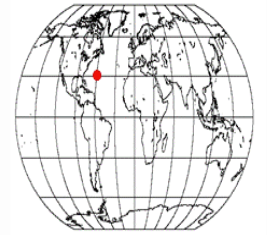

BATS (32°N –64°W) Bermuda Atlantic Time Series




We load the data:

In [ ]:
import scipy.io as sp
mat = sp.loadmat('VectLB19922008.mat') 

Vect=mat['Vect']

depth = mat['depth']


import pandas as pd

columns = ['SSH', 'CC', 'WS', 'SR','THERM 1', 'THERM 2', 'THERM 3', 'THERM 4', 'THERM 5', 'THERM 6', 'THERM 7', 'THERM 8', 'THERM 9', 'THERM 10', 'THERM 11', 'THERM 12', 'THERM 13', 'THERM 14', 'THERM 15', 'THERM 16', 'THERM 17', 'THERM 18', 'CHL 1', 'CHL 2', 'CHL 3', 'CHL 4', 'CHL 5', 'CHL 6', 'CHL 7', 'CHL 8', 'CHL 9', 'CHL 10', 'CHL 11', 'CHL 12', 'CHL 13', 'CHL 14', 'CHL 15', 'CHL 16', 'CHL 17', 'CHL 18', '5days', 'year', 'latitude', 'longitude']

df_train = pd.DataFrame(Vect, columns=columns)

df_train

VectLB19922008 cpntains the following variables:

{'SSH', 'CC', 'WS', 'SR','THERM 1', 'THERM 2', 'THERM 3', 'THERM 4', 'THERM 5',...
        'THERM 6', 'THERM 7', 'THERM 8', 'THERM 9', 'THERM 10', 'THERM 11', 'THERM 12',...
        'THERM 13', 'THERM 14', 'THERM 15', 'THERM 16', 'THERM 17', 'THERM 18', 'CHL 1',...
        'CHL 2', 'CHL 3', 'CHL 4', 'CHL 5', 'CHL 6', 'CHL 7', 'CHL 8', 'CHL 9', 'CHL 10',...
        'CHL 11', 'CHL 12', 'CHL 13', 'CHL 14', 'CHL 15', 'CHL 16', 'CHL 17', 'CHL 18', ...
        '5days', 'year', 'latitude', 'longitude'}

    %    i      | no. of 5 day step
    %    k      | no. year
    %    CHLORO | DCHL + NCHL  in [ng/l].
    %    SSH    | sea surface elevation
    %    CC     | cloud cover
    %    WS     | wind speed
    %    SR     | shortwave radiation
    %    Therm  | vertical thermic profile

Toidentify the data that belong to BATS, we need to filter them through latitude and longitude: 
usable=find((Vect(:,end) <= -63) & (Vect(:,end) >= -65) & (Vect(:,end-1)) >= 31 & (Vect(:,end-1) <= 33));

Depth provides the depth in meters.


In [ ]:
bats  = df_train.loc[(df_train['longitude'] >= -65) & (df_train['longitude'] <= -63) & (df_train['latitude'] >= 31) & (df_train['latitude'] <= 33)]
bats.sort_values(by=['year','5days'], inplace=True)

Let us examine one profile of Chlorophyll-A and one of Temperature.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

tmp0=bats.values[0,4:22]
tmp1=bats.values[0,22:40]
fig,ax = plt.subplots(figsize=[15,8],ncols=2,sharey=True)
ax[0].plot(tmp0,-1*depth[0:18],label='temperature',color='r')
ax[0].legend(loc=4)
ax[1].plot(tmp1,-1*depth[0:18],label='chlorophyll-a',color='g')
ax[1].legend(loc=4)


Let us also examine a year, here 1992.

In [ ]:
tmp2=bats.values[0:73,4:22]
tmp3=bats.values[0:73,22:40]
fig2,ax2 = plt.subplots(figsize=[50,8],nrows=2,sharey=True)

#ax2[0].contourf(np.flip(np.transpose(tmp2),axis=0),nchunk=40)

#ax2[1].contourf(np.flip(np.transpose(tmp3),axis=0),nchunk=40)
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[60, 0.5])
ax1 = fig2.add_subplot(gs[1, 0])
ax2 = fig2.add_subplot(gs[0, 0], sharex=ax1)
ax3 = fig2.add_subplot(gs[0, 1])
ax4 = fig2.add_subplot(gs[1, 1])


cont = ax1.contourf(np.flip(np.transpose(tmp2),axis=0),nchunk=40)
cont2 = ax2.contourf(np.flip(np.transpose(tmp3),axis=0),nchunk=40)

cbar = plt.colorbar(cont, cax=ax4)
cbar.set_label('Chl', rotation=270, labelpad=20)
cbar2 = plt.colorbar(cont2, cax=ax3)
cbar2.set_label('Temp', rotation=270, labelpad=20)
plt.tight_layout()
plt.show()

**Splitting the data into train and test** 

We are going to remove 4 years in order to have a test set, to ensure we are not overfitting our model.

In [ ]:
bats_train = bats[bats['year']<2004]
bats_train.sort_values(by=['year','5days'], inplace=True)

mn=np.mean(bats_train.values[:,0:40],axis=0)
sd=np.std(bats_train.values[:,0:40],axis=0)
invsd=1/sd
#bats_train.values[:,0:40]=(bats_train.values[:,0:40]-np.tile(mn, (bats_train.values.shape[0], 1)))*np.tile(invsd, (bats_train.values.shape[0], 1))

bats_test = bats[bats['year']>=2004]
bats_test.sort_values(by=['year','5days'], inplace=True)

#bats_test.values[:,0:40]=(bats_test.values[:,0:40]-np.tile(mn, (bats_test.values.shape[0], 1)))*np.tile(invsd, (bats_test.values.shape[0], 1))

**Creating an sData structure**

In [ ]:
from sompy import SOMData
from sompy import SOMFactory


In [ ]:
sData = SOMData(bats_train.values[:,0:40],      # les données .values
                bats_train.columns[0:40],# les noms des variables
                normalization = "var")

sData_test = SOMData(bats_test.values[:,0:40],      # les données .values
                bats_test.columns[0:40],# les noms des variables
                normalization = sData.component_normes)


#### Creating the topological map

In [ ]:
#mapsize=(7,7)
mapsize=(14,7) #the size is important, usually you need to do a pca of your dataset before hand and condition the proportions of dimension 1 vs dimension 2 to the ratio of eigenvalue 1 to eigenvalue 2. Why?
#mapsize=(20,20)


sm = SOMFactory().build(sData, 
                        mapsize=mapsize,
                        normalization = None, 
                        #initialization='random', # you can try this also
                        initialization='pca',  
                        radius_train ='linear', 
                        name='CHL',
                        #lattice='rect',
                        lattice='hexa',  #you can try this also
                        #mask=masque,
                        components_to_plot=((21,4),(22,4),(0,4),))

#### Entraînement de la carte

In [ ]:
sm.train(n_job=1, 
         verbose=None, 
         train_rough_len=40, 
         train_rough_radiusin=3,
         train_rough_radiusfin=1,
         train_finetune_len=80,
         train_finetune_radiusin=1.3,
         train_finetune_radiusfin=0.1,
         watch_evolution = False) #try with true


#### Other graphics :

- **Printing the map**

In [ ]:
from mapview import View2D
dim = sData._dim
col_sz = 4
view2D  = View2D(16,4*(dim/col_sz)*.6,
                 "codage ",
                 text_size=10)
view2D.show(sm, col_sz=col_sz, which_dim="all", denormalize=True) ; 

Printing an individual one

In [ ]:
view2D  = View2D(8,8,
                 "codage ",
                 text_size=10)
view2D.show(sm, col_sz=col_sz, which_dim=0, denormalize=True) ; 

What are the values of a cluster?

In [ ]:
print('number of clusters is: %s' % sm.codebook.nnodes) #number of classes

sm.codebook.matrix[0,:]

These values are not interpretable! We need to denormalize!

Creation of the denormalized map' codebook:

In [ ]:
sm_dn=(sm.codebook.matrix*np.tile(sd,(sm.codebook.matrix.shape[0],1)))+np.tile(mn,(sm.codebook.matrix.shape[0], 1))

In [ ]:
sm_dn[0,:]

Let us find to which cluster each data belongs:

In [ ]:
bats_train_n=(bats_train.values[:,0:40]-np.tile(mn, (bats_train.values.shape[0], 1)))*np.tile(invsd, (bats_train.values.shape[0], 1))
print(bats_train_n.shape)
bmus=sm.find_bmu(bats_train.values[:,0:40], njb=1, nth=1, metric='euclidean')
print(bmus.shape)
print(bmus[:,0])


A way to do it manually:

In [ ]:
from pandas.core.ops import frame_arith_method_with_reindex
from sklearn.metrics import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

fra=dist.pairwise(np.squeeze(bats_train.values[:,0:40]),np.squeeze(sm.codebook.matrix))
bmus_manual=np.argmin(fra,axis=1)
#bmus_manual

In [ ]:
dist_q=np.zeros(((bats_train.values.shape[0]),(sm.codebook.nnodes)))
for i in range(sm.codebook.nnodes):
  it=sm.codebook.matrix[i,:]
  dist_q[:,i]=(np.sum((bats_train_n[:,0:40]-np.tile(it, (bats_train.values.shape[0], 1)))**2))
#print(np.min(dist_q[0,:]))
#print(np.argmin(dist_q[0,:]))

Let us watch the vertical profiles of the first cluster:

In [ ]:
tmp3=sm_dn[0,4:22]
tmp4=sm_dn[0,22:40]
fig3,ax3 = plt.subplots(figsize=[15,8],ncols=2,sharey=True)
ax3[0].plot(tmp3,-1*depth[0:18],label='temperature',color='r')
ax3[0].legend(loc=4)
ax3[1].plot(tmp4,-1*depth[0:18],label='chlorophyll-a',color='g')
ax3[1].legend(loc=4)

- **Printing the indexes of the neurons to be able to identify them**

In [ ]:
view2D  = View2D(16,10,
                 "codage ",
                 text_size=10) ;
view2D.show(sm, neuronLabels=None,anotate=True, col_sz=1, which_dim=1, denormalize=True, labelsize=16) ; 

 - **Printing the number of hits per class**

In [ ]:
from bmuhits import BmuHitsView
vhts  = BmuHitsView(16,12,"Hits Map",text_size=20)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, logaritmic=False) ; 

 - **Printing the UMatrix (distances between referents/neurons)**

In [ ]:
from umatrix import UMatrixView
umat = UMatrixView(16,12,"Unified Distance Matrix", text_size=20)
umat.show(sm) ;

#### Evaluating the Map


 **Global errors**

In [ ]:
topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ("Topographic error  = %s\nQuantization error = %s" % (topographic_error, quantization_error))

**How did the map perform on the Test set?**

Use the previous functions to evaluate the results obtained.

What is the error we obtain when we change one year with its referent vectors?

In [ ]:
tmp2=bats.values[0:73,22:40]
tmp3=np.zeros(tmp2.shape)

for i in range(73):
  p=bmus[0,i]
  it=np.squeeze(sm_dn[int(p),22:40])
  tmp3[i,:]= it

fig2,ax2 = plt.subplots(figsize=[50,8],nrows=2,sharey=True)

#ax2[0].contourf(np.flip(np.transpose(tmp2),axis=0),nchunk=40)

#ax2[1].contourf(np.flip(np.transpose(tmp3),axis=0),nchunk=40)
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[60, 0.5])
ax1 = fig2.add_subplot(gs[1, 0])
ax2 = fig2.add_subplot(gs[0, 0], sharex=ax1)
ax3 = fig2.add_subplot(gs[0, 1])
ax4 = fig2.add_subplot(gs[1, 1])


cont = ax1.contourf(np.flip(np.transpose(tmp2),axis=0),nchunk=40)
cont2 = ax2.contourf(np.flip(np.transpose(tmp3),axis=0),nchunk=40)

cbar = plt.colorbar(cont, cax=ax4)
cbar.set_label('Chl', rotation=270, labelpad=20)
cbar2 = plt.colorbar(cont2, cax=ax3)
cbar2.set_label('Chl_SOM', rotation=270, labelpad=20)
plt.tight_layout()
plt.show()


And the difference:

In [ ]:
tmp2=bats.values[0:73,22:40]
tmp3=np.zeros(tmp2.shape)
for i in range(73):
  p=bmus[0,i]
  it=np.squeeze(sm_dn[int(p),22:40])
  tmp3[i,:]= it

tmp4=tmp2-tmp3

fig2,ax2 = plt.subplots(figsize=[50,8],nrows=1,sharey=True)

#ax2[0].contourf(np.flip(np.transpose(tmp2),axis=0),nchunk=40)

#ax2[1].contourf(np.flip(np.transpose(tmp3),axis=0),nchunk=40)
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[60, 0.5])
ax1 = fig2.add_subplot(gs[1, 0])
ax2 = fig2.add_subplot(gs[0, 0], sharex=ax1)
ax3 = fig2.add_subplot(gs[0, 1])
ax4 = fig2.add_subplot(gs[1, 1])


cont2 = ax2.contourf(np.flip(np.transpose(tmp2),axis=0),nchunk=40)
cbar = plt.colorbar(cont, cax=ax4,cmap="seismic")
cbar.set_label('Difference', rotation=270, labelpad=20)
cont = ax1.contourf(np.flip(np.transpose(tmp4),axis=0),nchunk=40,cmap="seismic")
cbar2 = plt.colorbar(cont2, cax=ax3)
cbar2.set_label('Chl_SOM', rotation=270, labelpad=20)



plt.tight_layout()
plt.show()


**Evaluating on one profile**


In [ ]:
tmp3=sm.codebook.matrix[9,4:22]
tmp4=sm.codebook.matrix[9,22:40]
fig3,ax3 = plt.subplots(figsize=[15,8],ncols=2,sharey=True)
fnd=np.squeeze(np.where(bmus[0,:]==9.))
for i in fnd:
  ax3[0].plot(bats_train.values[i,4:22],-1*depth[0:18],color='lightcoral',lw=1)
ax3[0].plot(tmp3,-1*depth[0:18],label='temperature',color='r',lw=5)
ax3[0].legend(loc=4)
for i in fnd:
  ax3[1].plot(bats_train.values[i,22:40],-1*depth[0:18],color='palegreen',lw=1)
ax3[1].plot(tmp4,-1*depth[0:18],label='chlorophyll-a',color='g',lw=5)
ax3[1].legend(loc=4)

You can denormalize and repreat the process for other clusters.


In [ ]:
tmp3=sm.codebook.matrix[9,4:22]*sd[4:22] + mn[4:22]
tmp4=sm.codebook.matrix[9,22:40]*sd[22:40] + mn[22:40]
fig3,ax3 = plt.subplots(figsize=[15,8],ncols=2,sharey=True)
fnd=np.squeeze(np.where(bmus[0,:]==9.))
for i in fnd:
  ax3[0].plot(bats_train.values[i,4:22]*sd[4:22] + mn[4:22],-1*depth[0:18],color='lightcoral',lw=1)
ax3[0].plot(tmp3,-1*depth[0:18],label='temperature',color='r',lw=5)
ax3[0].legend(loc=4)
for i in fnd:
  ax3[1].plot(bats_train.values[i,22:40]*sd[22:40] + mn[22:40],-1*depth[0:18],color='palegreen',lw=1)
ax3[1].plot(tmp4,-1*depth[0:18],label='chlorophyll-a',color='g',lw=5)
ax3[1].legend(loc=4)

**Projecting with partial data**

We might have better temperature reconstruction, or only satellite data. Do we still obtain good reconstructions of our Chlorophyll-A profiles?

In [ ]:
#use the manual calculation and let us consider we do not have access to the chlorophyll-A ie. we only compute the distance on sm.codebook.matrix[:,0:22] then repeat the process above to see if the reconstructions of temperature and chlorophyll-a are correct



Going further:

* Do not use the temperature profile to predict, is the prediciton still good?



In [ ]:
#use the manual calculation and let us consider we do not have access to non-surface data, ie. we only compute the distance on the elements 0:4 and 22

Temperature tends to organise the map more than Chlorophyll-A.
* Using log10 of chlorophyll or/and reducing the ammount of temperature profiles you add might help.

Cloud Cover is not a very useful information, consider removing it?

Are all depths important?

Additionally, we could add a seasonal information by transforming the 5days variable into a numerical continuous (see below) and including them as an input.

In [ ]:
sin_5days=np.sin(bats['5days'].values*2*np.pi/73)
cos_5days=np.cos(bats['5days'].values*2*np.pi/73) #why do we do this with cyclical variables?



Temporal information is missing right now from our model. 

* Perhaps using the sea-surface informations over many time steps can help the model?


**Further still:**

There are solutions out of the scape of this practical (ProfHMM, ItCompSOM, etc...)